In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.types import *
from pyspark.sql.functions import *

import warnings
warnings.filterwarnings('ignore')

# Q1

In [120]:
spark = SparkSession.builder.config('spark.ui.port', 64050).appName("ass1_q1").getOrCreate()

24/03/21 12:40:14 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


### (1)

In [121]:
schema = StructType([
	StructField("InvoiceNo", IntegerType(), False),     # 第三个：是否允许有空值
	StructField("StockCode", IntegerType(), False),
	StructField("Description", StringType(), False),
	StructField("Quantity", IntegerType(), False),
	StructField("InvoiceDate", StringType(), False),
	StructField("UnitPrice", FloatType(), False),
	StructField("CustomerID", IntegerType(), False),
	StructField("Country", StringType(), False)
])
df = spark.read.csv("./data/Q1_data/retail-dataset.csv", header=True, schema=schema)
df.show(5)
df.count()


+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|   536365|     NULL|WHITE HANGING HEA...|       6|12/1/2010 8:26|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|     NULL|CREAM CUPID HEART...|       8|12/1/2010 8:26|     2.75|     17850|United Kingdom|
|   536365|     NULL|KNITTED UNION FLA...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|     NULL|RED WOOLLY HOTTIE...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
only showing top 5 rows



541909

In [122]:
df_clean = df.dropna().filter((col("Quantity") > 0) & (col("UnitPrice")> 0))
df_clean.show(5)
df_clean.count()

+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|    22752|SET 7 BABUSHKA NE...|       2|12/1/2010 8:26|     7.65|     17850|United Kingdom|
|   536365|    21730|GLASS STAR FROSTE...|       6|12/1/2010 8:26|     4.25|     17850|United Kingdom|
|   536366|    22633|HAND WARMER UNION...|       6|12/1/2010 8:28|     1.85|     17850|United Kingdom|
|   536366|    22632|HAND WARMER RED P...|       6|12/1/2010 8:28|     1.85|     17850|United Kingdom|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
only showing top 5 rows



363087

### (2)

In [123]:
df_clean.select(expr("sum(UnitPrice * Quantity) as total_cost")).show()

+----------------+
|      total_cost|
+----------------+
|8015349.50373831|
+----------------+



### (3)

In [124]:
df_clean.groupBy("CustomerID").agg(expr("sum(UnitPrice * Quantity) as total_cost")).select(col("CustomerID"),col("total_cost")).orderBy("total_cost",ascending = False).show(5)

+----------+------------------+
|CustomerID|        total_cost|
+----------+------------------+
|     14646|265106.91930553317|
|     18102| 253922.7600557804|
|     17450| 180847.0303592682|
|     16446|168472.49374997616|
|     14911|125544.34975004196|
+----------+------------------+
only showing top 5 rows



### (4)

In [125]:
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

In [126]:
df_4 = df_clean.withColumn("InvoiceDate", to_timestamp(col("InvoiceDate"), "MM/dd/yyyy HH:mm"))
df_4.select(max("InvoiceDate"), min("InvoiceDate")).show()

+-------------------+-------------------+
|   max(InvoiceDate)|   min(InvoiceDate)|
+-------------------+-------------------+
|2011-12-09 12:50:00|2010-12-01 08:26:00|
+-------------------+-------------------+



In [127]:
list = df_4.where("InvoiceDate between '2010-12-01' and '2010-12-05' ").groupBy("Country").agg(expr("sum(UnitPrice * Quantity) as total_cost ")).select(col("Country"),col("total_cost")).collect()

country_list = [i["Country"] for i in list]
cost_list = [i["total_cost"] for i in list]

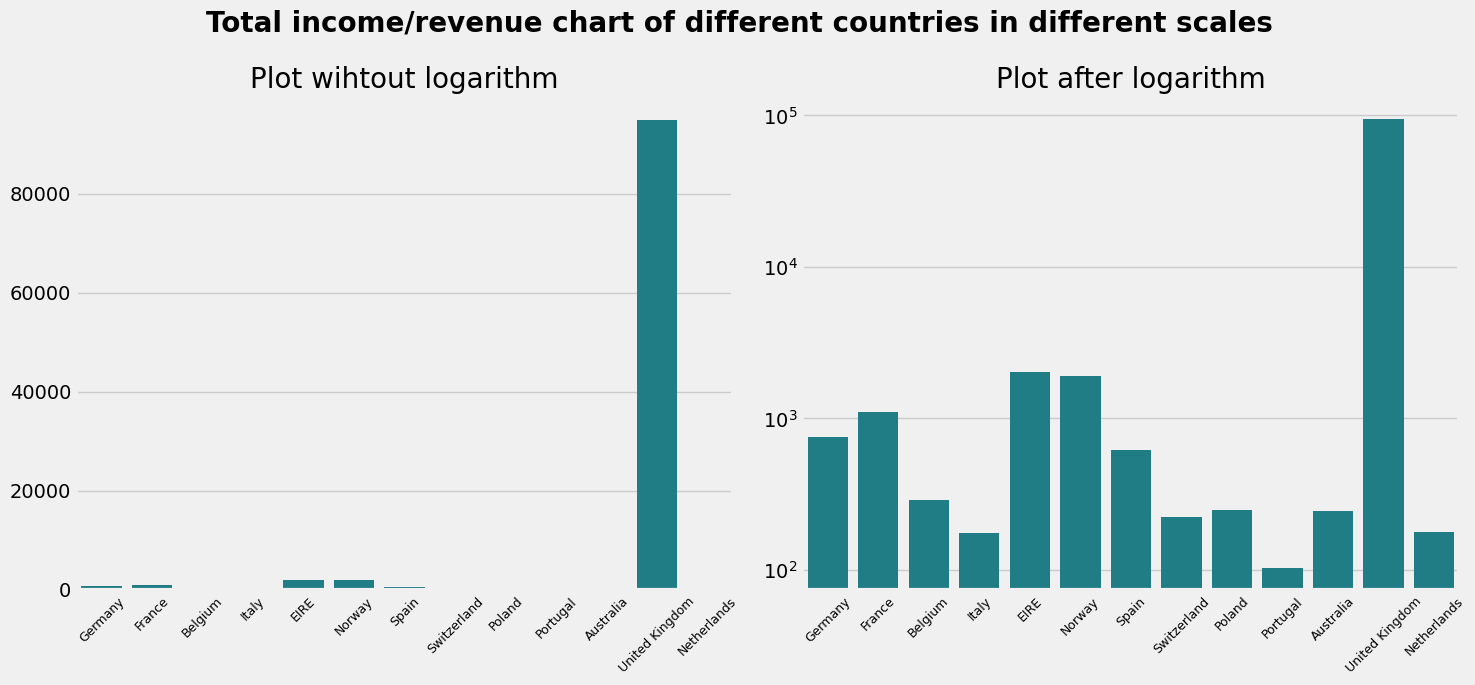

In [128]:
plt.style.use("fivethirtyeight")

fig, axs = plt.subplots(1, 2, figsize=(15, 7))  # 创建画布，用于放置子图，并让所有子图共享 y 轴
# 给总画布取名字, 左对齐，虽然但是也要在x = 0.05的位置
plt.suptitle("Total income/revenue chart of different countries in different scales", fontsize=20,weight='bold') 
# 添加副标题

# 微调子图间距以及绘图区域的相对位置
plt.subplots_adjust(top = 0.8)

sns.barplot(x=country_list, y=cost_list,ax = axs[0],color = "#108b96")
axs[0].set_title("Plot wihtout logarithm", fontsize=20)
axs[0].set_xticklabels(country_list, rotation=45, fontsize=9)

sns.barplot(x=country_list, y=cost_list,ax = axs[1],color = "#108b96")
axs[1].set_yscale('log')
axs[1].set_title("Plot after logarithm", fontsize=20)
axs[1].set_xticklabels(country_list, rotation=45, fontsize=9);

fig.tight_layout()
fig.savefig("./output/q1_4.svg")

In [129]:
spark.stop()

# Q2

### (1)

In [130]:
spark = SparkSession.builder.config('spark.ui.port', 64050).appName("ass1_q2").getOrCreate()

In [131]:
df = spark.read.text("data/Q2_data/SRR12326717_1_Light_Bulk.csv")

col_name = (df.tail(2)[0]["value"]).split(",")
data = [df.tail(1)[0]["value"].split(",")]
df1 = spark.createDataFrame(data,col_name)
df1.show()

+--------------------+-----+----------+-----------+------------+----------+--------+------------+-----------+------+--------+--------------------+--------------------+---------------------+---------------------+-----------------+---------------+-----------------+---------------+-----------------+---------------+--------------------+-----------------------+--------------------+-----------------------+--------------------+-----------------------+--------------------+-----------------------+--------------------+-----------------------+--------------------+-----------------------+--------------------+--------------------+--------------------+--------+--------------------+-----------------+---------+-------+--------------------+--------------------+--------------------+----------+--------------------+-----------+--------------------+---------------+-------------+------------------+-------+-------+-------+-------------+-------+-------------+----------+---------+---------+----------+---------

it is not useful, let's change the method

In [132]:
import os
csv_list = [p for p in os.listdir(path = "data/Q2_data") if p.endswith(".csv")]

# 读取第一个 CSV 文件来初始化 DataFrame
df = spark.read.format("csv").option("header","True").option("comment","\"").load(f"data/Q2_data/{csv_list[0]}")

# 从第二个文件开始，读取每一个 CSV 文件并进行合并
for i in csv_list[1:]:
    temp_df = spark.read.format("csv").option("header","True").option("comment","\"").load(f"data/Q2_data/{i}")
    df = df.union(temp_df)

df.count()

87508

In [133]:
df_remove = df.select(col("sequence_alignment_aa"),col("cdr1_aa"),col("cdr2_aa"),col("cdr3_aa")).where((length(col("cdr3_aa"))>=10) &  (length(col("cdr3_aa"))<=100 ))
df_remove.show(5)
df_remove.count()

+---------------------+---------+-------+------------+
|sequence_alignment_aa|  cdr1_aa|cdr2_aa|     cdr3_aa|
+---------------------+---------+-------+------------+
| QSVLTQPPSVSGTPGQR...| DSNIGNNF|    KTS| AAWDDPLNAVL|
| GVPDRFSGSTSGTSASL...|     NULL|   NULL|QSFDNSLGGFYV|
| QSALTQPPSASGTPGQR...| RSNIGINT|    SND| DAWDDNLNGPV|
| QSALTQPASMSGSPGQS...|SSDVGASNH|    EVS|  YSYAVGVTFV|
| TLSLTCGSSTGAVHSGY...|TGAVHSGYY|    STD|LLYFGGIQPLWV|
+---------------------+---------+-------+------------+
only showing top 5 rows



17156

In [134]:
df_remove.coalesce(1).write.format("csv").mode("overwrite").save("output/output_data/q2_pyspark.csv")

In [135]:
spark.stop()

# Q(3)

``` bash
#!/bin/bash

output_file="output/output_data/q2(2)_sh.csv"

# 如果输出文件已存在，则删除它
if [ -f $output_file ]; then
    rm $output_file
fi

# 获取 CSV 文件列表
csv_list=$(ls data/Q2_data/*.csv)

# 从每个 CSV 文件中读取内容（不包括头部），并追加到结果文件
for file in $csv_list
do
    # 使用 awk 提取需要的列，然后使用 grep 删除 cdr3_aa 长度小于 10 或大于 100 的行
    awk -F, 'NR>2 {if (length($47)>=10 && length($47)<=100) print $14","$37","$41","$47}' $file >> temp.csv
done

# 提取第一个文件的标题行(第二行)，并写入最终的 CSV 文件
sed -n '2p' $(echo $csv_list | awk '{print $1}') | awk -F, '{print $14","$37","$41","$47}' > $output_file

# 将临时文件的内容追加到最终的 CSV 文件，并删除临时文件
cat temp.csv >> $output_file
rm temp.csv

wc $output_file
```



# Q(4)

``` bash
#!/bin/bash

# mkdir "output/output_data/q2(3)"

# 定义输出文件路径
output_file="output/output_data/q2(3)_sh.csv"

# 如果输出文件已存在，则删除它
if [ -f $output_file ]; then
    rm $output_file
fi

# 指定需要分割的大文件
large_file="data/Q2_data/SRR12326775_1_Light_Bulk.csv"

# 这个命令首先会使用 tail -n +3 命令从原始文件的第三行开始，将所有行输出到一个名为 temp.csv 的临时文件中。然后，它会使用 split 命令将这个临时文件分割为8个部分，每个部分的文件名都以 chunk 开头。最后，它删除临时文件 temp.csv
tail -n +3 $large_file > temp.csv
split -n l/8 -d --additional-suffix=.csv temp.csv chunk
rm temp.csv


chunk_list=$(ls chunk*.csv)
for chunk in $chunk_list; do
    file_name=${chunk:5}
    awk -F, 'NR>0 {if (length($47)>=10 && length($47)<=100) print $14","$37","$41","$47}' $chunk > temp${file_name}.csv &
done

wait

# 提取第一个文件的标题行(第二行)，并写入最终的 CSV 文件
sed -n '2p' $large_file | awk -F, '{print $14","$37","$41","$47}' > $output_file

# 将临时文件的内容追加到最终的 CSV 文件
cat temp*.csv >> $output_file

# 删除临时文件和文件块
rm chunk*.csv temp*.csv

# 显示输出文件的行数、字数和字符数
wc $output_file

```